In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objects as go
from sklearn import preprocessing
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.options.display.max_colwidth = 2000

In [ ]:
with open('credentials.json') as f:
    credentials = json.load(f)
    
username = credentials['username'] # your username
api_key = credentials['api_key'] #your plotly api key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

### Read in cleaned and tokenized 311 HPD claims

In [ ]:
df_311_wide = pd.read_csv("data/HPD_311_all_cleaned_tagged.csv", dtype = {'incident_zip_str':'str', }, parse_dates = ['created_date', 'closed_date', 'resolution_action_updated_date'])
print(df_311_wide.shape)

In [ ]:
#Creating separate dataset to analyze so that if I later want to drop anything I easily can
to_analyze = df_311_wide.copy()

### Create source/target dataframe from the process and outcome tokens
- source/target define the source and target of each edge
- num_records will be the edge weight
- token_type source defines whether the source node is a process or outcome node

**By changing the process_variable and outcome_variable you can change the complexity of the network created**

In [66]:
variables_to_plot = {'ungrouped':('ultimate_outcome', 'ultimate_process'), 'grouped':('grouped_ultimate_outcome', 'grouped_ultimate_process')}

which_variable = 'ungrouped' #Change this to change which set of variables you want to plot from variables to plot
process_variable = variables_to_plot[which_variable][0]
outcome_variable = variables_to_plot[which_variable][1]

In [67]:
#Grouped process and outcome tags
df_by_process_outcome = pd.DataFrame(to_analyze.groupby([process_variable, outcome_variable])['unique_key'].nunique()).reset_index()
df_by_process_outcome.columns = ['source', 'target', 'num_records']
df_by_process_outcome['token_type_source'] = 'process'

#Create opposite set to have all pairwise combinations listed in both directions
df_by_process_outcome_bidirectional = df_by_process_outcome[['target', 'source', 'num_records']]
df_by_process_outcome_bidirectional.columns = ['source', 'target', 'num_records']
df_by_process_outcome_bidirectional['token_type_source'] = 'outcome'

#Concatenate
df_by_process_outcome_grouped = pd.concat([df_by_process_outcome, df_by_process_outcome_bidirectional], axis = 0, ignore_index = True)

df_by_process_outcome_grouped

,source,target,num_records,token_type_source
0,CLOSED THIS COMPLAINT ADMINISTRATIVELY,RESOLUTION PROCESS UNKNOWN,24530,process
1,COMPLAINT CONDITIONS ARE STILL OPEN,RESOLUTION PROCESS UNKNOWN,81461,process
2,COMPLAINT WAS ADDRESSED,CONTACTED AN OCCUPANT,12298,process
3,CONDITIONS WERE CORRECTED,CONTACTED A TENANT,686980,process
4,DID NOT HAVE ENOUGH TIME TO INSPECT,ATTEMPTED AND FAILED TO INVESTIGATE ORIGINAL PROPERTY,13,process
5,IDENTIFIED POTENTIAL LEAD,RESOLUTION PROCESS UNKNOWN,38759,process
6,LITERATURE HAS BEEN MAILED,LITERATURE PREPARATION,33113,process
7,LITERATURE WILL BE EMAILED WITHIN 24 HOURS,LITERATURE PREPARATION,18058,process
8,NO VIOLATIONS WERE ISSUED,AT THE TIME OF THE INSPECTION,3822,process
9,NO VIOLATIONS WERE ISSUED,ATTEMPTED AND FAILED TO INVESTIGATE ORIGINAL PROPERTY,15017,process


In [68]:
#Create a dictionary of all the tokens with their types - necessary for coloring the nodes
tokens = list(df_by_process_outcome['source'].unique())
type_tokens = ['process']*len((list(df_by_process_outcome['source'].unique())))
                   
tokens.extend(list(df_by_process_outcome['target'].unique()))
type_tokens.extend(['outcome']*len((list(df_by_process_outcome['target'].unique()))))
                   
type_dict = pd.DataFrame({'token':tokens, 'type_token':type_tokens})
type_dict

,token,type_token
0,CLOSED THIS COMPLAINT ADMINISTRATIVELY,process
1,COMPLAINT CONDITIONS ARE STILL OPEN,process
2,COMPLAINT WAS ADDRESSED,process
3,CONDITIONS WERE CORRECTED,process
4,DID NOT HAVE ENOUGH TIME TO INSPECT,process
5,IDENTIFIED POTENTIAL LEAD,process
6,LITERATURE HAS BEEN MAILED,process
7,LITERATURE WILL BE EMAILED WITHIN 24 HOURS,process
8,NO VIOLATIONS WERE ISSUED,process
9,NOT ABLE TO GAIN ACCESS,process


### Scale the num_records to edge weights that will plot nicely

In [69]:
#Scales weights linearly to between 1 and 5
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,5))
transformed = min_max_scaler.fit_transform(df_by_process_outcome_grouped['num_records'].values.reshape(-1,1))
transformed = [item[0] for item in transformed]
df_by_process_outcome_grouped['weight'] = transformed
print(transformed)

[1.055585596308955, 1.1846610779529212, 1.0278528796612765, 2.5575099049465218, 1.0, 1.0878459646199279, 1.075045202831766, 1.0409121052900068, 1.0086358663923323, 1.0340174689815052, 5.0, 3.7869475760512845, 2.1291060892040337, 1.1871731651051143, 1.0012900519761714, 1.9832712680031968, 1.0006008150679886, 1.012864244134968, 1.01183945767938, 3.3954972878300937, 1.3005367659145142, 1.055585596308955, 1.1846610779529212, 1.0278528796612765, 2.5575099049465218, 1.0, 1.0878459646199279, 1.075045202831766, 1.0409121052900068, 1.0086358663923323, 1.0340174689815052, 5.0, 3.7869475760512845, 2.1291060892040337, 1.1871731651051143, 1.0012900519761714, 1.9832712680031968, 1.0006008150679886, 1.012864244134968, 1.01183945767938, 3.3954972878300937, 1.3005367659145142]


### Create a Graph object in networkx library

In [70]:
G = nx.from_pandas_edgelist(df_by_process_outcome_grouped, source='source', target='target',  edge_attr= True)

### Plot basic network visualization to make sure graph object works


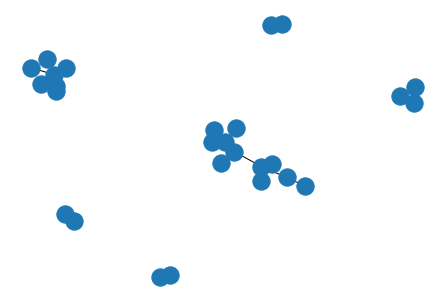

In [71]:
nx.draw(G)
plt.draw()

### Use plotly to create interactive and nicely formatted version of this network

#### Calculate positions of nodes in G using specified layout
- Also tried circular_layout, kamanda_kawai_layout, and bi-partite layout, but found spring layout to be best.

*weight*: Specifies that the weight column should be used to weight the edges

*k*: Controls the distance between nodes. NetworkX documentation explains that the optimal distance between nodes set to 1/sqrt(n) by default (this is .25 for the grouped graph), but I found nodes were crowding so I increased it.


In [72]:
pos = nx.spring_layout(G, weight='weight', k=.33)

### Format data to work in a plotly graph object

Thanks to Rebecca Weng for her great blog post on this! You can find the original code that I've modified slightly for my purposes here: https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9

### Create a separate edge trace for each edge in order to end up with weighted edges
Plotly doesn't natively allow for weighted edges

In [73]:
# Custom function to create an edge between node x and node y, with a given text and width
def make_edge(x, y, text, width):
    return  go.Scatter(x = x,
                       y = y,
                       line = dict(width = width,
                                   color = 'black'),
                       hoverinfo = 'text',
                       text = ([text]),
                       mode = 'lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in G.edges():
#     print(edge)
#     print(G.edges()[edge]['weight'])
    if G.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]
    x0, y0 = pos[char_1]

    x1, y1 = pos[char_2]
    text = char_1 + '--' + char_2 + ': ' + str(G.edges()[edge]['weight'])

    trace = make_edge([x0, x1, None], [y0, y1, None], text, width = G.edges()[edge]['weight'])
    edge_trace.append(trace)

### Create node trace

In [74]:
node_x = []
node_y = []
node_names = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_names.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    text=node_names,
    mode='markers',
    hoverinfo='text',
    textposition = 'top center',
    marker=dict(size=10,
    line_width=2))

### Color nodes by process/outcome

In [75]:
node_colors = []
for node in node_names:
    print(node)
    type_val = type_dict[type_dict['token'] == node]['type_token'].iloc[0]
    if type_val == 'process':
        node_colors.append('#148E82')
    elif type_val == 'outcome':
        node_colors.append('#B53C09')
        
node_trace.marker.color = node_colors

CLOSED THIS COMPLAINT ADMINISTRATIVELY
RESOLUTION PROCESS UNKNOWN
COMPLAINT CONDITIONS ARE STILL OPEN
COMPLAINT WAS ADDRESSED
CONTACTED AN OCCUPANT
CONDITIONS WERE CORRECTED
CONTACTED A TENANT
DID NOT HAVE ENOUGH TIME TO INSPECT
ATTEMPTED AND FAILED TO INVESTIGATE ORIGINAL PROPERTY
IDENTIFIED POTENTIAL LEAD
LITERATURE HAS BEEN MAILED
LITERATURE PREPARATION
LITERATURE WILL BE EMAILED WITHIN 24 HOURS
NO VIOLATIONS WERE ISSUED
AT THE TIME OF THE INSPECTION
INSPECTED THE FOLLOWING CONDITIONS
NOT ABLE TO GAIN ACCESS
ORIGINAL COMPLAINT IS STILL OPEN
OUTCOME UNKNOWN CLOSED
CONDUCTED OR ATTEMPTED TO CONDUCT AN INSPECTION
RESTORED
ADVISED BY A TENANT IN THE BUILDING
SECTION 8 FAILURE WAS ISSUED
VIOLATION WAS ISSUED
BY INSPECTING ANOTHER APARTMENT
VIOLATIONS WERE ISSUED
VIOLATIONS WERE PREVIOUSLY ISSUED


### Size nodes by number of records they are associated with

In [76]:
#Calculate the number of records that contain the token represented by each node (used to size node)
num_records_by_node_process = pd.DataFrame(to_analyze.groupby([process_variable])['unique_key'].nunique()).reset_index()
num_records_by_node_process.columns = ['node', 'num_records']

num_records_by_node_outcome = pd.DataFrame(to_analyze.groupby([outcome_variable])['unique_key'].nunique()).reset_index()
num_records_by_node_outcome.columns = ['node', 'num_records']

#Concatenate
num_records_by_node = pd.concat([num_records_by_node_process, num_records_by_node_outcome], ignore_index = True, sort = False)
num_records_by_node.set_index('node', inplace = True)
num_records_by_node.loc[node_names]
num_records_by_node.reset_index(inplace = True)

#Scales weights linearly to between 1 and 5
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(20,50))
transformed_size = min_max_scaler.fit_transform(num_records_by_node['num_records'].values.reshape(-1,1))
transformed_size = [int(item[0]) for item in transformed_size]
num_records_by_node['node_size'] = transformed_size
print(transformed_size)
node_trace.marker.size = transformed_size

[20, 20, 20, 26, 20, 20, 20, 20, 38, 32, 25, 20, 24, 20, 20, 30, 21, 24, 20, 32, 20, 20, 26, 20, 50, 20, 26]


### Plot the network

In [79]:
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
    title = "Co-occurence of keywords from the NYC housing department's description of 311 complaint resolution",
    title_font_color="black",
    title_font_size = 15,
    title_x = .1,
    title_y = .9,

)

# Create figure
fig = go.Figure(layout = layout)

# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
    
# Add node trace
fig.add_trace(node_trace)

# Remove legend
fig.update_layout(showlegend = False, width = 900, height = 500)

# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)

# Show figure
fig.show()

#Write to HTML
fig.write_html('output/network_process_outcome_{}.html'.format(which_variable))

In [80]:
py.plot(fig, filename = '311_network_process_outcome'.format(which_variable), auto_open=True)

'https://plotly.com/~mhersher/11/'